In [2]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

from params import AttrDict, params as base_params
from model import DiffWave

device = 'cuda' if torch.cuda.is_available else 'cpu'

def load_model(model_dir=None, device='cpu', params=None):
    model = DiffWave(AttrDict(base_params)).to(device)
    checkpoint = torch.load(model_dir)
    model.load_state_dict(checkpoint)
    model.eval()
    model.params.override(params)
    
    return model
    

def predict(spectrogram=None, model=None, params=None, device='cpu', fast_sampling=False):
    
    with torch.no_grad():
        training_noise_schedule = np.array(model.params.noise_schedule)
        inference_noise_schedule = np.array(model.params.inference_noise_schedule) if fast_sampling else training_noise_schedule

        talpha = 1 - training_noise_schedule
        talpha_cum = np.cumprod(talpha)

        beta = inference_noise_schedule
        alpha = 1 - beta
        alpha_cum = np.cumprod(alpha)
        
        T = []
        for s in range(len(inference_noise_schedule)):
            for t in range(len(training_noise_schedule)-1):
                if talpha_cum[t+1] <= alpha_cum[s] <= talpha_cum[t]:
                    twiddle = (talpha_cum[t]**0.5 - alpha_cum[s]**0.5) / (talpha_cum[t]**0.5 - talpha_cum[t+1]**0.5)
                    T.append(t + twiddle)
                    break
        T = np.array(T, dtype=np.float32)
        
        if not model.params.unconditional:
            if len(spectrogram.shape) == 2:
                # adding a batch dimension
                spectrogram = torch.FloatTensor(spectrogram)
                spectrogram = spectrogram.unsqueeze(0)
            spectrogram = spectrogram.to(device)
            signal = torch.randn(1, params.audio_len, device=device)
        else:
            signal = torch.randn(1, params.audio_len, device=device)
            noise_scale = torch.from_numpy(alpha_cum**0.5).float().unsqueeze(1).to(device)
        
        for n in range(len(alpha) - 1, -1, -1):
            c1 = 1 / alpha[n]**0.5
            c2 = beta[n] / (1 - alpha_cum[n])**0.5
            signal = c1 * (signal - c2 * model(signal, torch.tensor([T[n]], device=signal.device), spectrogram).squeeze(1))
            if n > 0:
                noise = torch.randn_like(signal)
                sigma = ((1.0 - alpha_cum[n-1]) / (1.0 - alpha_cum[n]) * beta[n])**0.5
                signal += sigma * noise
                signal = torch.clamp(signal, -1.0, 1.0)
                
        #return signal, model.params.sample_rate
        return signal

In [2]:
model_eval =  load_model(model_dir='model_dir_conditional/20.pth', 
                         params=base_params)

# abnormal: ['1001', '1002', '1014', '1017', '1018', '1029', '1036', '1037', '1039', '1041', '1042', '1044']
# normal: 

In [3]:
abnormal_name = ['1001', '1002', '1014', '1017', '1018', '1029', '1036', '1037', '1039', '1041', '1042', '1044']

abnormal = []
normal = []

for file in os.listdir('../test set'):
    if file[0:4] in abnormal_name:
        abnormal.append(file)
    else:
        normal.append(file)
        
abnormal = abnormal
normal = normal[0:len(abnormal)]

# conditional inference - replace part of the real data with generated data 

In [16]:
from scipy.signal import decimate

#generated_signals = np.empty([0, 2400])
def downsampling(signal):
    downsampled_signal = decimate(signal, q=2, n=None, ftype='iir', axis=-1, zero_phase=True)

    return downsampled_signal

def denormalization(ori_signal, signal):
    max_val = max(ori_signal)
    min_val = min(ori_signal)
    denormalized_signal = signal * (max_val - min_val) + min_val
    
    return denormalized_signal

def generate_signal(spectrogram_filename):
    spectrogram = np.load(spectrogram_filename)
    ori_signal = np.load(os.path.join('../test set', os.path.basename(spectrogram_filename)))
    ori_signal = downsampling(ori_signal)
    signal = predict(spectrogram=spectrogram,
                    model = model_eval,
                    fast_sampling=False,
                    params=base_params)
    #signal = downsampling(signal)
    signal = np.array(signal[0])
    signal = (signal + 1) / 2
    signal = denormalization(ori_signal, signal) 

    
    if len(ori_signal) != len(signal):
        raise ValueError("The two arrays must have the same length")
        
    return ori_signal, signal
    
    '''
    np.save('model_dir_conditional/generated/normal/' + os.path.basename(spectrogram_filename), data[0])
    plt.figure(figsize = (12,4))
    plt.plot(data[0])
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.savefig('model_dir_conditional/generated/normal/'+os.path.basename(spectrogram_filename)[:-4]+'.png')
    '''
    
def replace_data(start, end, ori_signal, signal):
    
    q1_idx = int(len(ori_signal) * start)
    q2_idx = int(len(ori_signal) * end)
    ori_signal[q1_idx:q2_idx] = signal[q1_idx:q2_idx]
    
    return ori_signal
        
    
for file in normal:
    path = os.path.join('../spectrograms', file)
    # 25% replace
    ori_signal, signal = generate_signal(path)
    replaced_signal = replace_data(0.25, 0.5, ori_signal, signal)
    np.save('model_dir_conditional/generated/6-data augmentation/normal/25/'+os.path.basename(path)[:-4]+'_25.npy', replaced_signal)
    # 50% replace
    ori_signal, signal = generate_signal(path)
    replaced_signal = replace_data(0.25, 0.75, ori_signal, signal)
    np.save('model_dir_conditional/generated/6-data augmentation/normal/50/'+os.path.basename(path)[:-4]+'_50.npy', replaced_signal)
    # 70% replace
    ori_signal, signal = generate_signal(path)
    replaced_signal = replace_data(0.25, 1, ori_signal, signal)
    np.save('model_dir_conditional/generated/6-data augmentation/normal/75/'+os.path.basename(path)[:-4]+'_75.npy', replaced_signal)

    
    

# conditional inference 

In [ ]:
from scipy.signal import decimate

#generated_signals = np.empty([0, 2400])
def downsampling(signal):
    downsampled_signal = decimate(signal, q=2, n=None, ftype='iir', axis=-1, zero_phase=True)

    return downsampled_signal

def generate_signal(spectrogram_filename):
    spectrogram = np.load(spectrogram_filename)
    ori_signal = np.load(os.path.join('../test set', os.path.basename(spectrogram_filename)))
    ori_signal = downsampling(ori_signal)
    signal = predict(spectrogram=spectrogram,
                    model = model_eval,
                    fast_sampling=False,
                    params=base_params)
    signal = downsampling(signal)
    
    data = np.array(signal) * 160 + 100
    np.save('model_dir_conditional/generated/normal/' + os.path.basename(spectrogram_filename), data[0])
    plt.figure(figsize = (12,4))
    plt.plot(data[0])
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.savefig('model_dir_conditional/generated/normal/'+os.path.basename(spectrogram_filename)[:-4]+'.png')
    


for file in normal:
    generate_signal(os.path.join('../spectrograms', file))

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


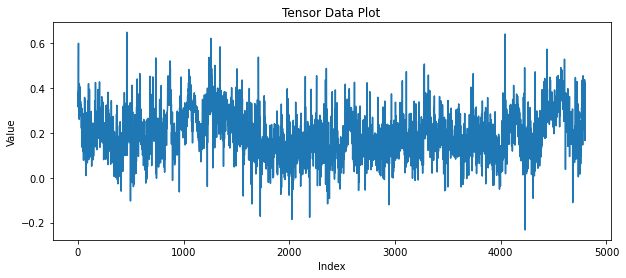

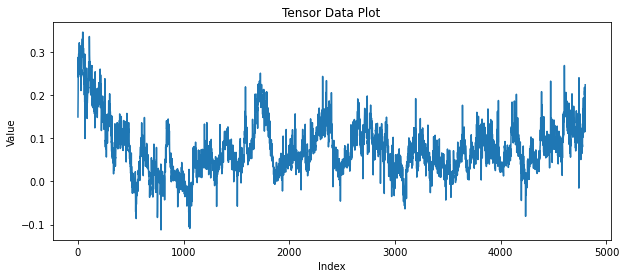

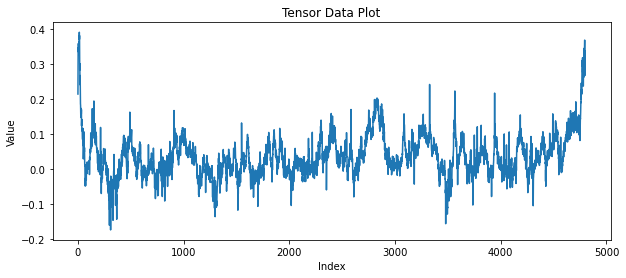

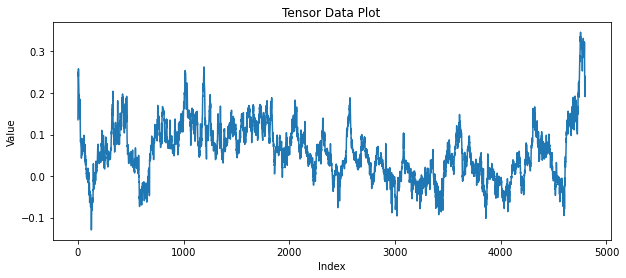

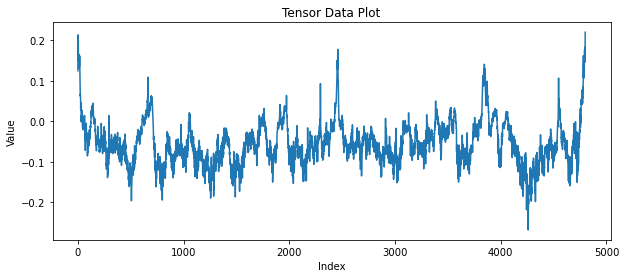

In [2]:
#signal = np.array(signal)
#generated_signals = np.vstack((generated_signals, signal))
    
#generated_signals


signal1, sr = predict(spectrogram=None,
                    model_dir='model_dir/1.pth',
                    fast_sampling=False,
                    params=base_params)

tensor_data = np.array(signal1)

signal2, sr = predict(spectrogram=None,
                    model_dir='model_dir/2.pth',
                    fast_sampling=False,
                    params=base_params)
tensor_data2 = np.array(signal2)

signal3, sr = predict(spectrogram=None,
                    model_dir='model_dir/3.pth',
                    fast_sampling=False,
                    params=base_params)
tensor_data3 = np.array(signal3)

signal4, sr = predict(spectrogram=None,
                    model_dir='model_dir/4.pth',
                    fast_sampling=False,
                    params=base_params)
tensor_data4 = np.array(signal4)

signal5, sr = predict(spectrogram=None,
                    model_dir='model_dir/5.pth',
                    fast_sampling=False,
                    params=base_params)
tensor_data5 = np.array(signal5)



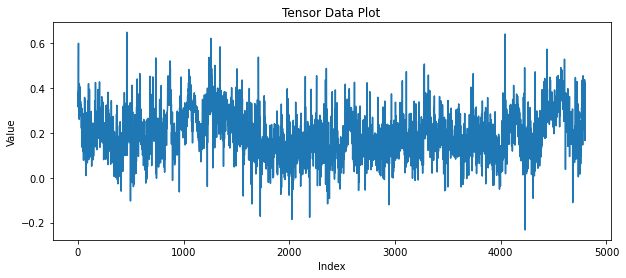

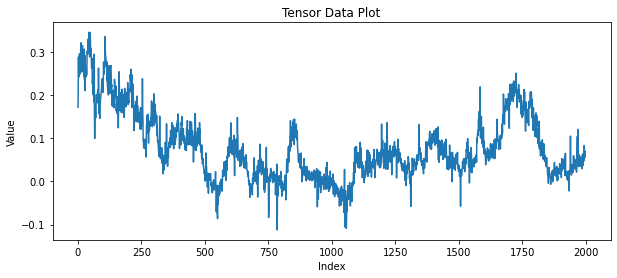

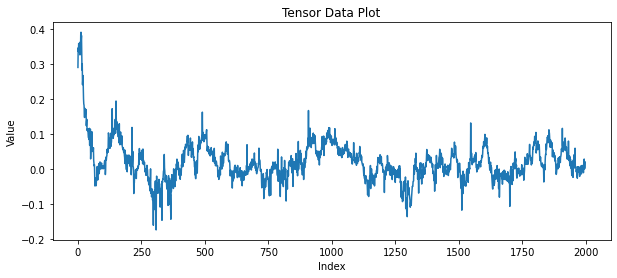

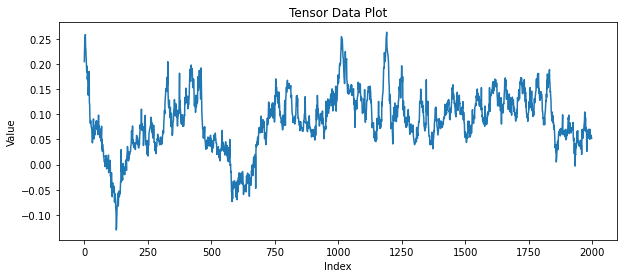

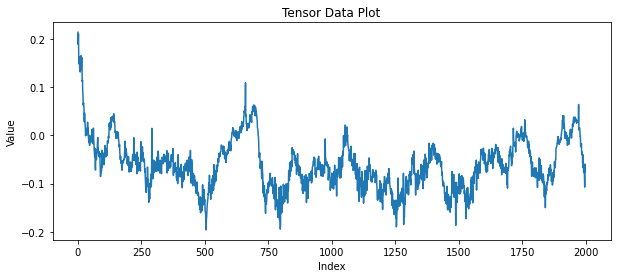

In [70]:
# 使用Matplotlib画出数据
plt.figure(figsize=(10, 4))
plt.plot(tensor_data[0])
plt.title("Tensor Data Plot")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


# 使用Matplotlib画出数据
plt.figure(figsize=(10, 4))
plt.plot(tensor_data2[0][1:2000])
plt.title("Tensor Data Plot")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


# 使用Matplotlib画出数据
plt.figure(figsize=(10, 4))
plt.plot(tensor_data3[0][1:2000])
plt.title("Tensor Data Plot")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


# 使用Matplotlib画出数据
plt.figure(figsize=(10, 4))
plt.plot(tensor_data4[0][1:2000])
plt.title("Tensor Data Plot")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


# 使用Matplotlib画出数据
plt.figure(figsize=(10, 4))
plt.plot(tensor_data5[0][1:2000])
plt.title("Tensor Data Plot")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()



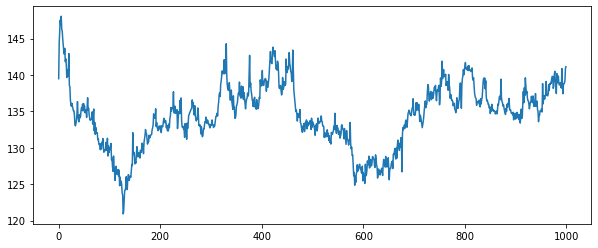

In [20]:
signal5

# 定义FHR信号的实际范围
min_value = 60
max_value = 200
normalized_signal = signal4

# 将归一化的FHR信号转换回原始的范围
original_signal = min_value + ((normalized_signal + 1) * (max_value - min_value) / 2)
plt.figure(figsize=(10, 4))
plt.plot(original_signal[0][0:1000])
plt.show()


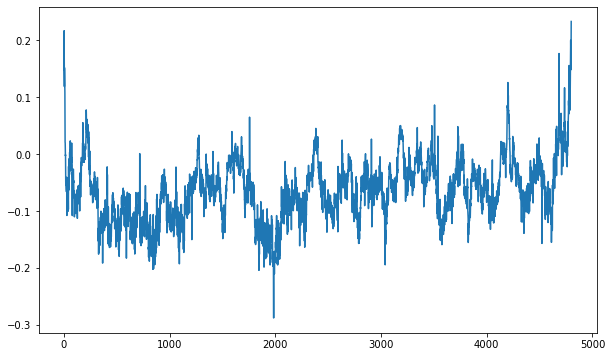

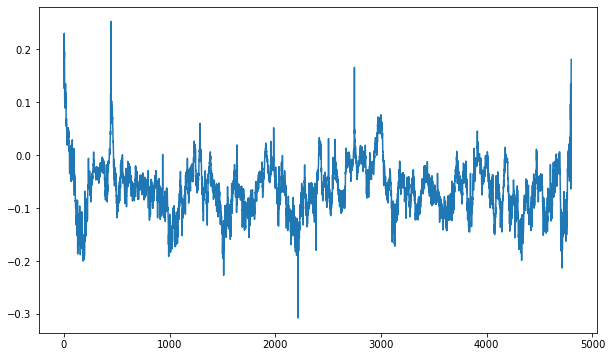

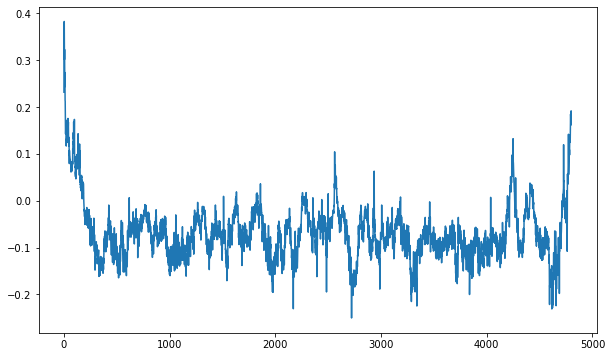

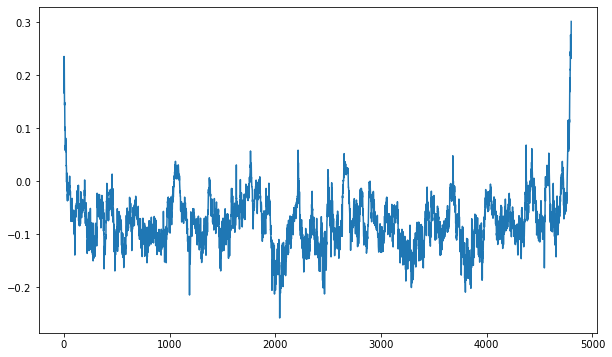

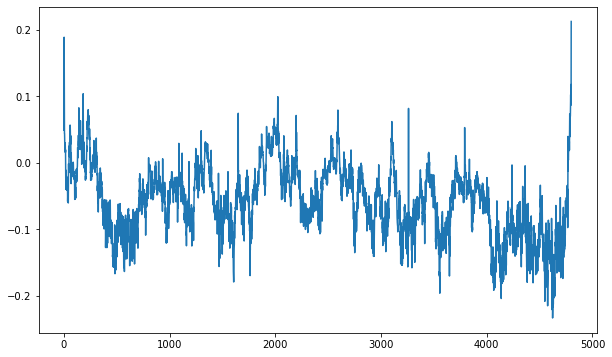

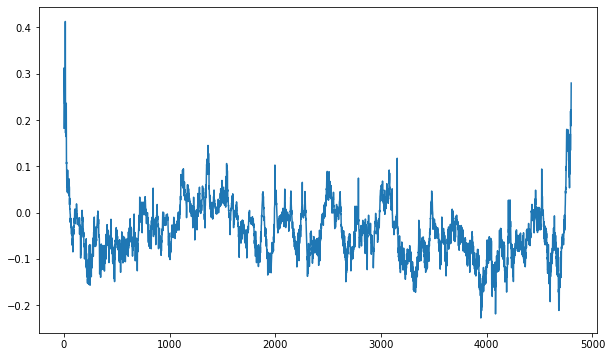

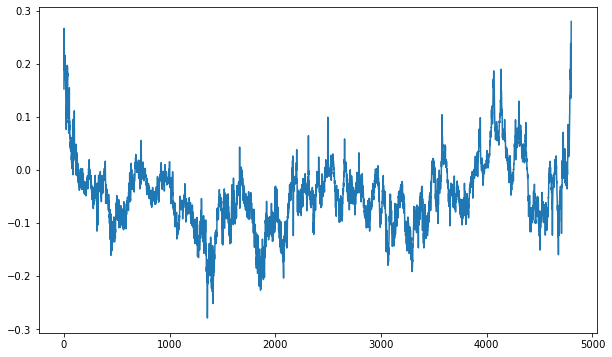

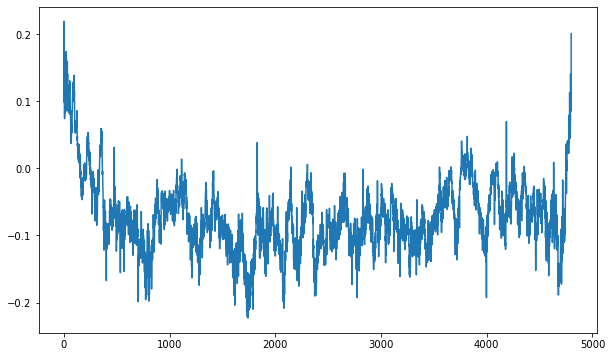

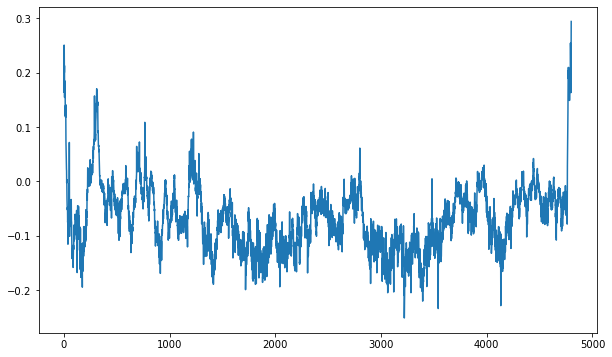

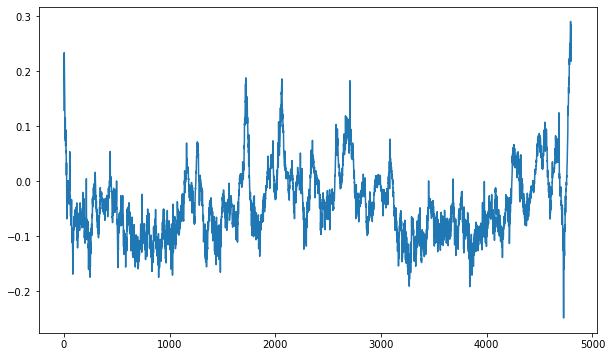

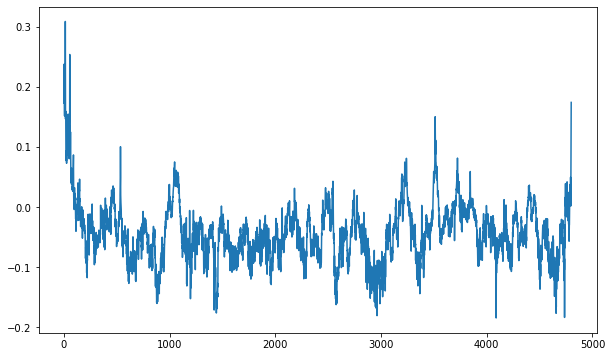

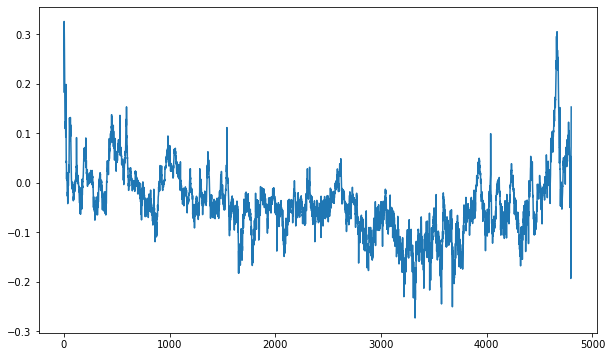

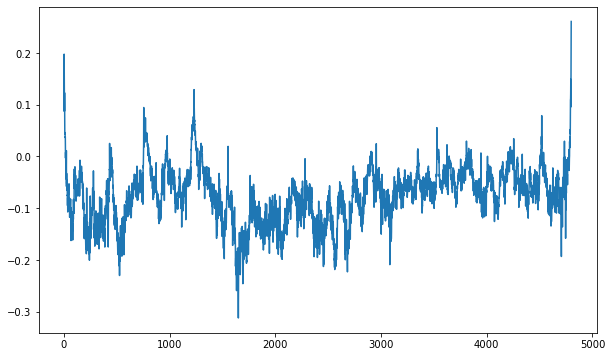

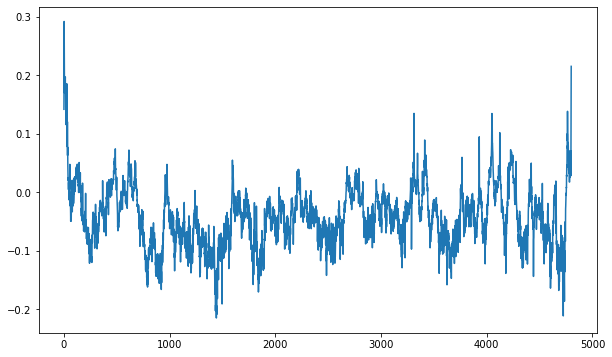

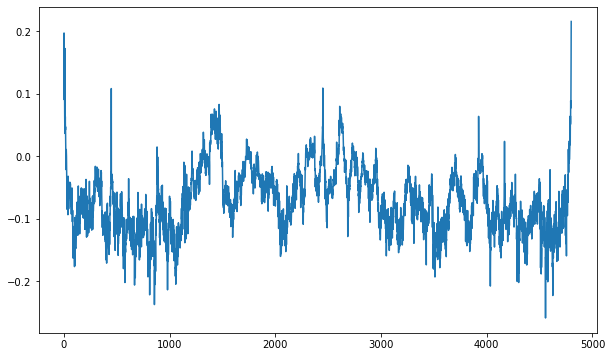

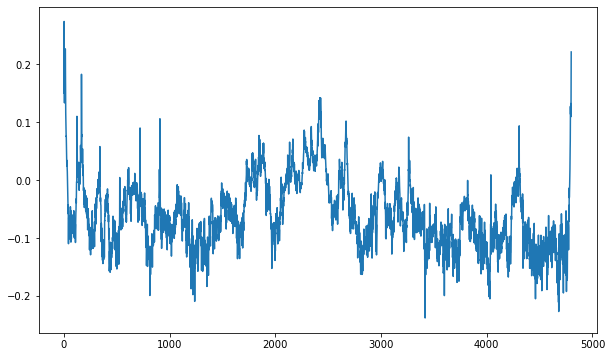

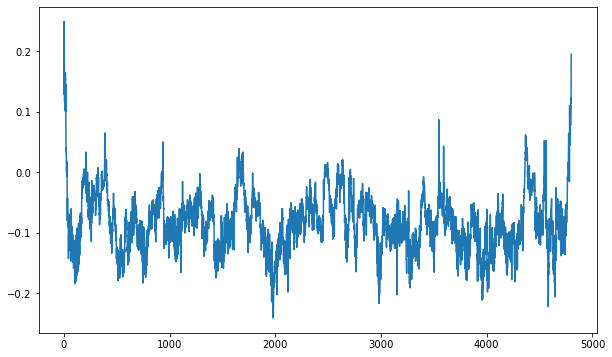

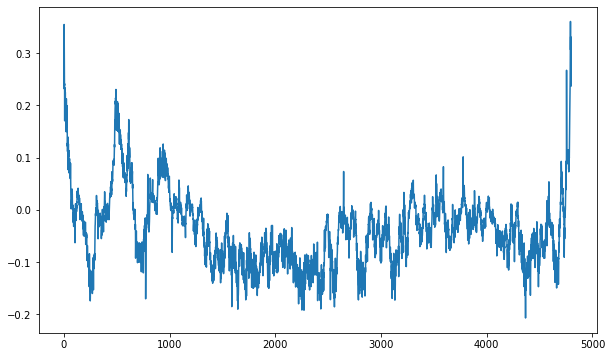

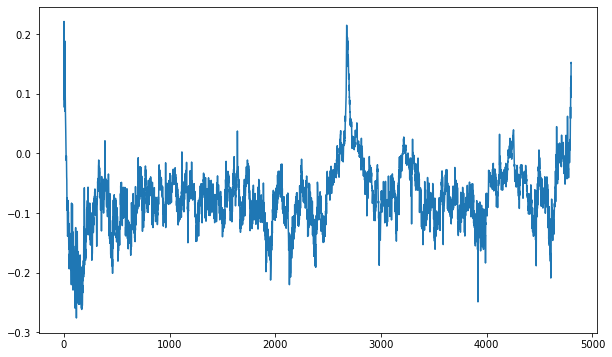

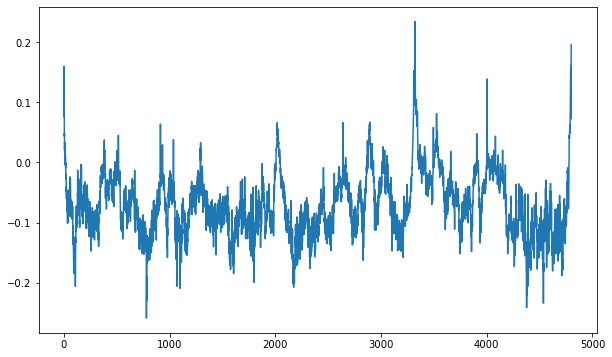

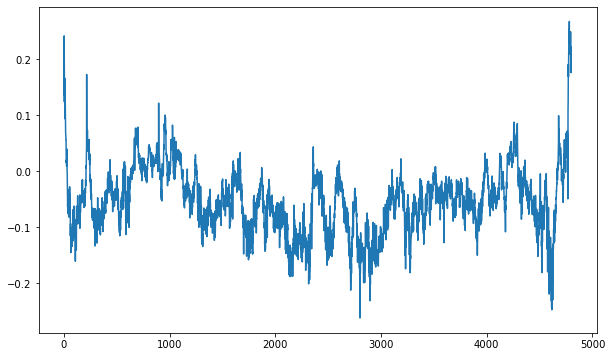

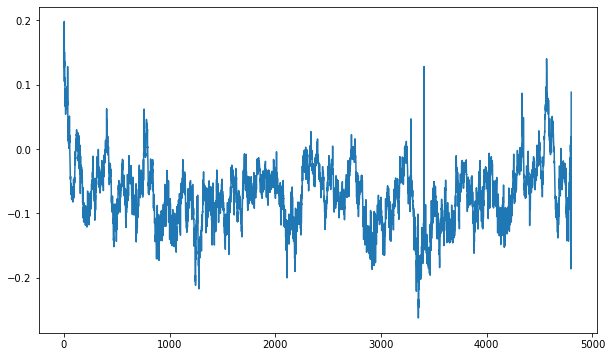

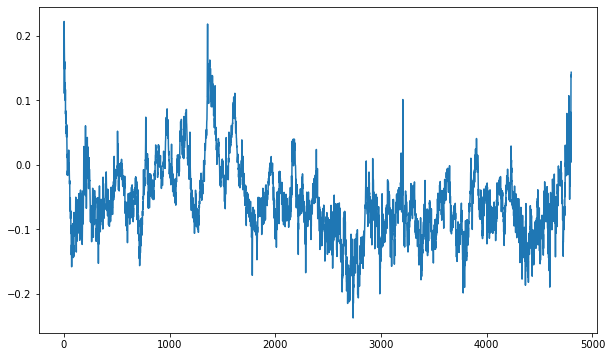

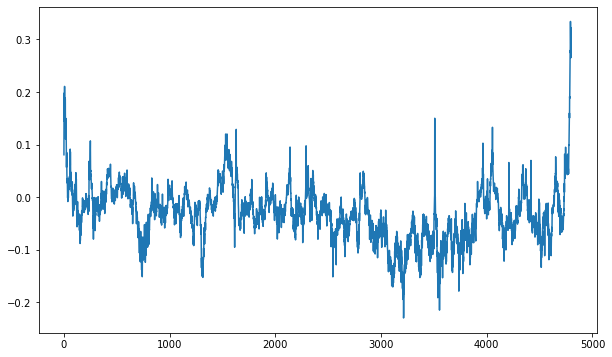

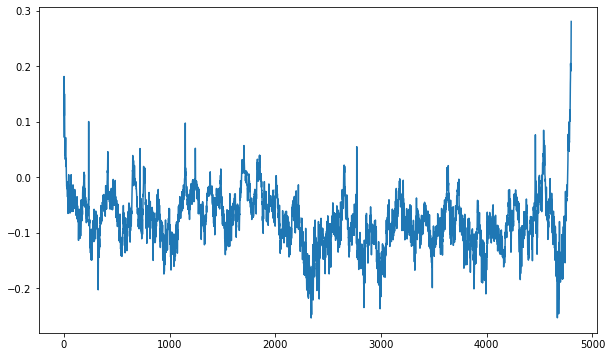

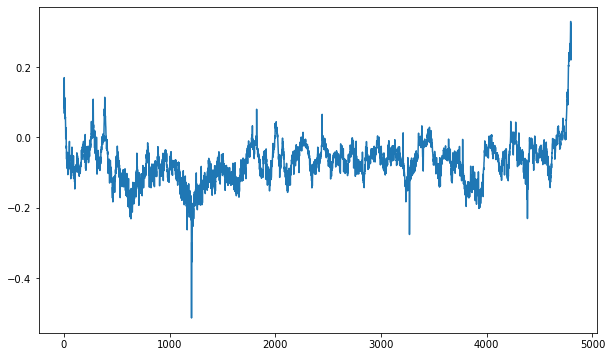

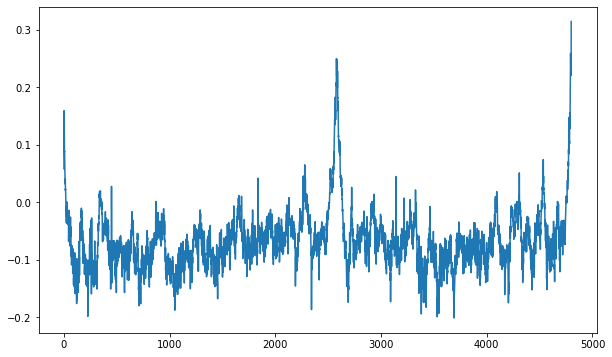

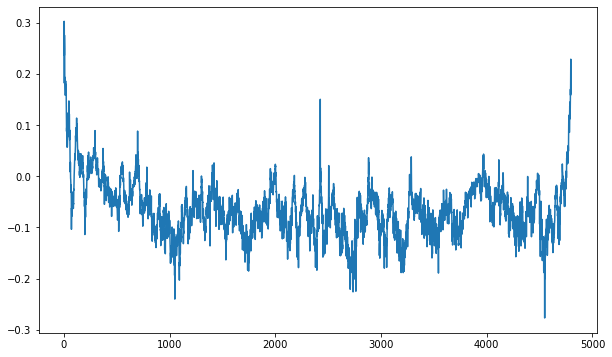

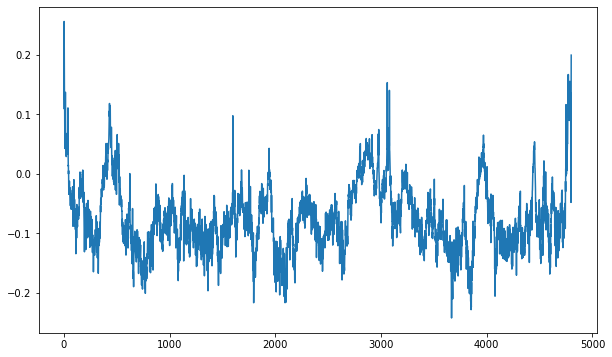

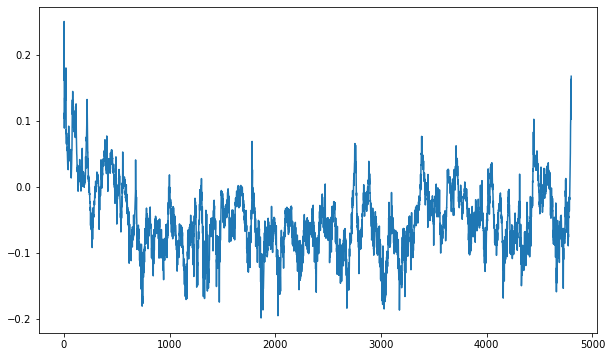

In [68]:
generated_signals = np.load('model_dir0406/generated_data5.npy')
for i in range(generated_signals.shape[0]):
    signal = generated_signals[i]
    plt.figure(figsize=(10, 6))  # 可以调整图表大小
    plt.plot(signal)
    plt.show()

In [2]:
generated_signals = np.load('model_dir0406/generated_data5.npy')
generated_signals.shape

(30, 4800)

In [80]:
def max_min_normalization(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    normalized_signal = (signal - min_val) / (max_val - min_val)
    
    return normalized_signal

real_list = ['1110_1.npy', '1110_2.npy', '1111_0.npy', '1111_1.npy', '1111_2.npy', '1112_0.npy', '1114_3.npy', 
             '1114_0.npy', '1114_1.npy', '1114_2.npy', '1117_1.npy', '1118_2.npy', '1118_0.npy',  
             '1118_1.npy', '1126_1.npy', '1126_2.npy', '1126_3.npy', '1139_1.npy', '1139_2.npy', '1139_3.npy', 
             '1146_0.npy', '1146_1.npy', '1147_0.npy', '1147_1.npy', '1147_2.npy', '1149_3.npy', '1149_2.npy', '1150_0.npy',  
             '1151_2.npy', '1151_1.npy']

real_data = np.empty((0,4800))

for i in range(len(real_list)):
    signal = np.load(os.path.join('../fragments', real_list[i]))
    signal = max_min_normalization(signal)
    real_data = np.vstack((real_data, signal))
    
np.save('model_dir0406/real_data.npy', real_data)

In [16]:
def plot_signal(signal, title):
    plt.figure(figsize=(12, 4))
    plt.rcParams['figure.dpi'] = 150
    
    plt.plot(signal, color='blue', linestyle='-', linewidth=1.5)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Time (samples)", fontsize=14)
    plt.ylabel("Amplitude", fontsize=14)
    
    # 自动调整Y轴范围，增加上下边距
    min_val, max_val = np.min(signal), np.max(signal)
    y_margin = (max_val - min_val) * 0.1  # 增加10%的边距
    plt.ylim(min_val - y_margin, max_val + y_margin)
    
    # X轴范围，左右各留一定空白
    x_margin = len(signal) * 0.05  # 左右各留5%的边距
    plt.xlim(-x_margin, len(signal) + x_margin)
    
    # 添加网格线
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # 设置刻度和标签的大小
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
    plt.savefig('../paper_plotting/preprocessing.jpg')
    plt.show()


In [2]:
model_uncon = load_model(model_dir='model_dir0406/5.pth',params=base_params)

In [3]:
signal1 = predict(spectrogram=None, model=model_uncon, params=base_params, device='cpu', fast_sampling=False)
signal2 = predict(spectrogram=None, model=model_uncon, params=base_params, device='cpu', fast_sampling=False)
signal3 = predict(spectrogram=None, model=model_uncon, params=base_params, device='cpu', fast_sampling=False)


#plot_signal(np.array(signal1[0]), 'Unconditional DDPM: sample 1')
#plot_signal(np.array(signal2[0]), 'Unconditional DDPM: sample 2')
#plot_signal(np.array(signal3[0]), 'Unconditional DDPM: sample 3')

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [3]:
model_con =  load_model(model_dir='model_dir_conditional/20.pth', params=base_params)

In [ ]:
spectrogram1 = np.load('../1-data/spectrograms/1009_0.npy')
spectrogram2 = np.load('../1-data/spectrograms/1016_0.npy')
spectrogram3 = np.load('../1-data/spectrograms/1050_0.npy')
spectrogram4 = np.load('../1-data/spectrograms/1028_0.npy')

signal4 = predict(spectrogram=spectrogram1, model = model_con, fast_sampling=False, params=base_params)
signal5 = predict(spectrogram=spectrogram2, model = model_con, fast_sampling=False, params=base_params)
signal6 = predict(spectrogram=spectrogram3, model = model_con, fast_sampling=False, params=base_params)

signal7 = predict(spectrogram=spectrogram1, model = model_con, fast_sampling=False, params=base_params)
signal8 = predict(spectrogram=spectrogram2, model = model_con, fast_sampling=False, params=base_params)
signal9 = predict(spectrogram=spectrogram3, model = model_con, fast_sampling=False, params=base_params)
signal10 = predict(spectrogram=spectrogram1, model = model_con, fast_sampling=False, params=base_params)
signal11 = predict(spectrogram=spectrogram2, model = model_con, fast_sampling=False, params=base_params)
signal12 = predict(spectrogram=spectrogram3, model = model_con, fast_sampling=False, params=base_params)
signal13 = predict(spectrogram=spectrogram1, model = model_con, fast_sampling=False, params=base_params)
signal14 = predict(spectrogram=spectrogram2, model = model_con, fast_sampling=False, params=base_params)
signal15 = predict(spectrogram=spectrogram3, model = model_con, fast_sampling=False, params=base_params)

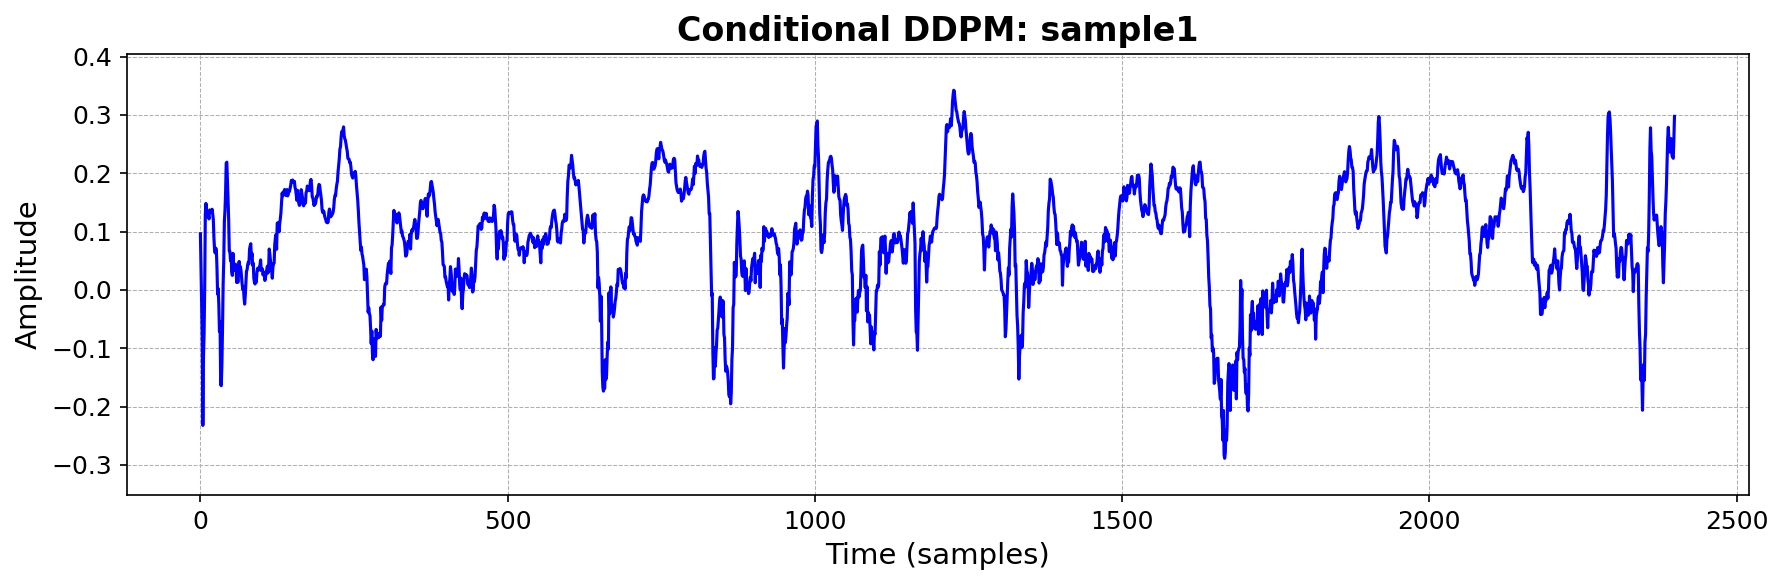

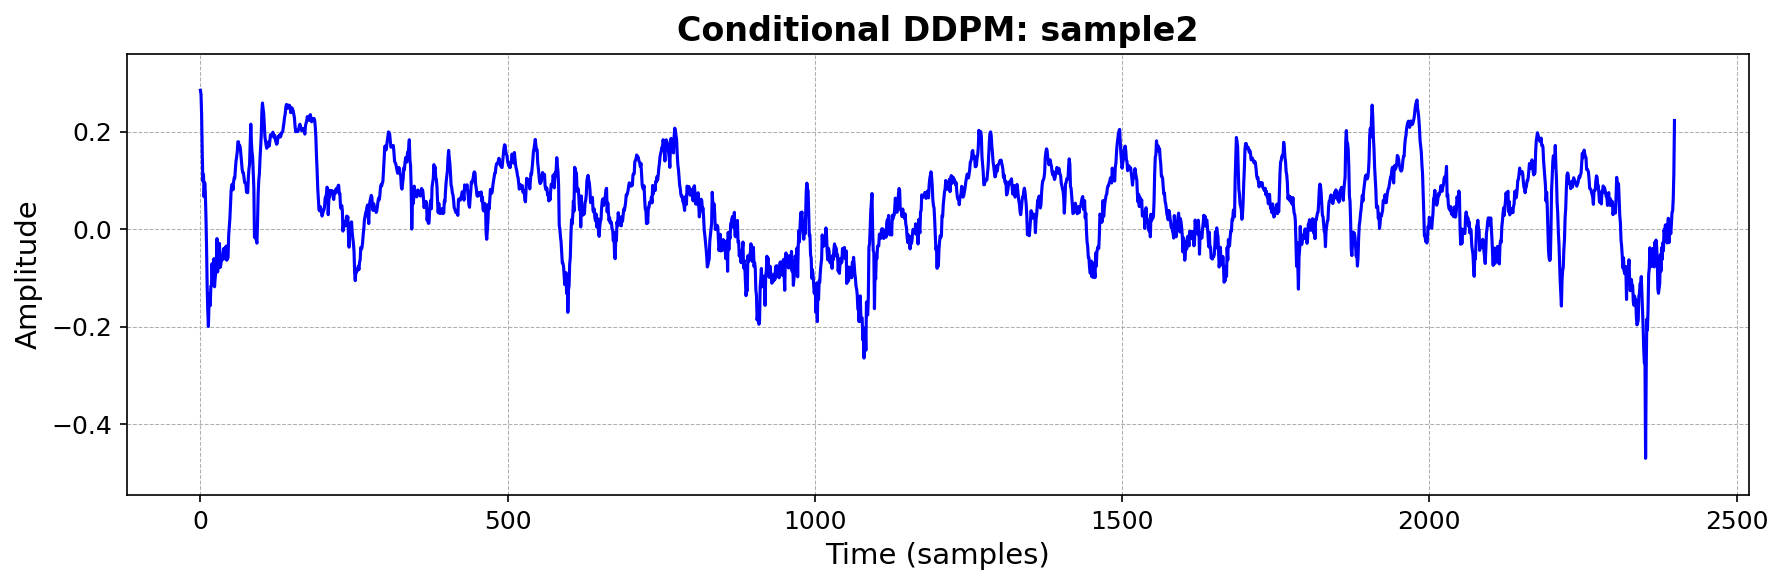

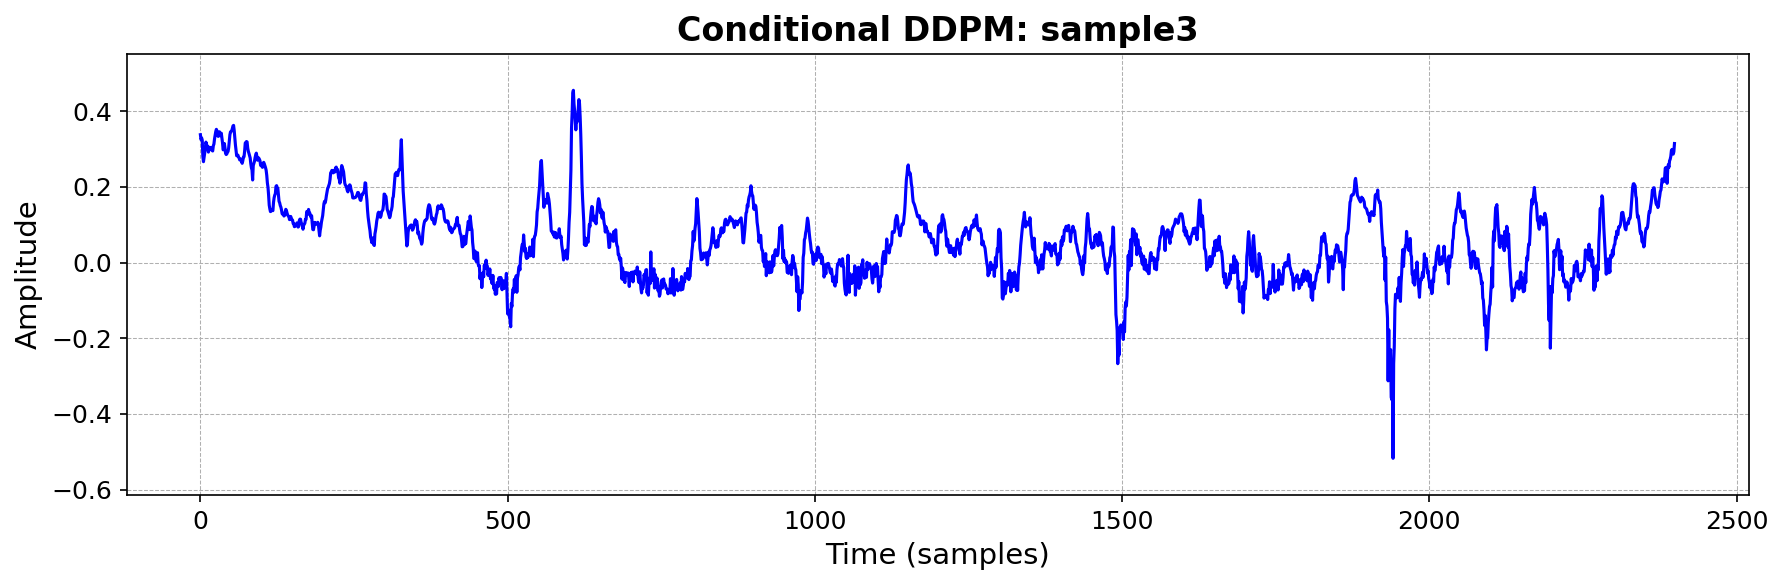

In [17]:
plot_signal(np.array(signal5[0]), 'Conditional DDPM: sample1')

plot_signal(np.array(signal6[0]), 'Conditional DDPM: sample2')

plot_signal(np.array(signal7[0]), 'Conditional DDPM: sample3')

In [ ]:
plot_signal(np.array(signal4[0][:1200]), 'Conditional DDPM: sample1')
plot_signal(np.array(signal4[0][1200:]), 'Conditional DDPM: sample1')

plot_signal(np.array(signal5[0][:1200]), 'Conditional DDPM: sample2')
plot_signal(np.array(signal5[0][1200:]), 'Conditional DDPM: sample2')

plot_signal(np.array(signal6[0][:1200]), 'Conditional DDPM: sample3')
plot_signal(np.array(signal6[0][1200:]), 'Conditional DDPM: sample3')

plot_signal(np.array(signal7[0][:1200]), 'Conditional DDPM: sample4')
plot_signal(np.array(signal7[0][1200:]), 'Conditional DDPM: sample4')

plot_signal(np.array(signal8[0][:1200]), 'Conditional DDPM: sample5')
plot_signal(np.array(signal8[0][1200:]), 'Conditional DDPM: sample5')

plot_signal(np.array(signal9[0][:1200]), 'Conditional DDPM: sample6')
plot_signal(np.array(signal9[0][1200:]), 'Conditional DDPM: sample6')

plot_signal(np.array(signal10[0][:1200]), 'Conditional DDPM: sample7')
plot_signal(np.array(signal10[0][1200:]), 'Conditional DDPM: sample7')

plot_signal(np.array(signal11[0][:1200]), 'Conditional DDPM: sample8')
plot_signal(np.array(signal11[0][1200:]), 'Conditional DDPM: sample8')

plot_signal(np.array(signal12[0][:1200]), 'Conditional DDPM: sample9')
plot_signal(np.array(signal12[0][1200:]), 'Conditional DDPM: sample9')

plot_signal(np.array(signal13[0][:1200]), 'Conditional DDPM: sample10')
plot_signal(np.array(signal13[0][1200:]), 'Conditional DDPM: sample10')

plot_signal(np.array(signal14[0][:1200]), 'Conditional DDPM: sample11')
plot_signal(np.array(signal14[0][1200:]), 'Conditional DDPM: sample11')

plot_signal(np.array(signal15[0][:1200]), 'Conditional DDPM: sample12')
plot_signal(np.array(signal15[0][1200:]), 'Conditional DDPM: sample12')

In [ ]:
model_uncon = load_model(model_dir='model_dir0406/5.pth',params=base_params)
fhr_signals = []
for i in range(60):
    signal = predict(spectrogram=None, model=model_uncon, params=base_params, device='cpu', fast_sampling=False)
    fhr_signals.append(signal)
    save_path = 'pca/uncon/' + str(i) + '.npy'
    np.save(save_path, signal)

In [7]:
import random 

testing = os.listdir('../1-data/1-generation/testing')
#selected = random.sample(testing, 176)
spectrograms_path = [os.path.join('../1-data/spectrograms', file) for file in testing]
#spectrograms = [np.load(file) for file in spectrograms_path]
model_con =  load_model(model_dir='model_dir_conditional/20.pth', params=base_params)
fhr_signals = []
for path in spectrograms_path:
    spectrogram = np.load(path)
    signal = predict(spectrogram=spectrogram, model = model_con, fast_sampling=False, params=base_params)
    save_path = 'pca/con/' + os.path.basename(path)
    np.save(save_path, signal)
    fhr_signals.append(signal)